In [37]:
import pandas as pd
import numpy as np
import torch
import plot_helper
from catboost import CatBoostClassifier, Pool
from transformers import AutoModel
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("data/train.csv")
print(df.columns.tolist())
name_columns = pd.read_csv("data/train_labels.csv")

['axrlqygbssxu', 'firstname', 'lon', 'firm', 'fxvspjlbgrhm', 'jqfyjomipilf', 'location_id', 'phone_number', 'eosogjttsvtt', 'org_id', 'state', 'aevtkbjhhryq', 'customer_iban', 'departmentsid', 'switching_center_lat', 'relationship_status', 'phone_no', 'aoprdggmbtuz', 'wage', 'customer_email', 'country', 'family_email', 'countyname', 'vcqcujsmuukw', 'ywpjaeadqwwj', 'active', 'rrubbcpjrqht', 'kgazxjkrlqja', 'benefitdaycare', 'iinelubpyelh', 'gbhwunppuetx', 'lat', 'province', 'kdxrpomztopy', 'neighbourhood', 'jtklraxdukre', 'nkoyzuojoair', 'phone_ext', 'ssn', 'dqshzbqqvqdc', 'person_surname', 'lng', 'ukofatwbaafw', 'ijfsukxdjfhd', 'flikvuanjlbz', 'bndecuspucsy', 'datum_izvestaja', 'last_name', 'road_name', 'kozakymqwsyw', 'uniquemastercitizennumber', 'road_name.1', 'geo_latitude', 'street', 'homephone', 'uniform_civil_number', 'tzvshsmubghm', 'company_name', 'userid', 'cell_phone_number', 'psspt id', 'pwd_argon', 'phone', 'zudlvyipnzyv', 'husipigzonkk', 'aagvnhasmkig', 'customer_name', 'p

In [38]:
# add type data how catigorical feature for catboost 
# add name columns for embedding
# add custom features (*)
# size in database
# change model embedding
# clean dataset

In [39]:
train_dataset = pd.DataFrame(
    zip(df.columns.tolist(), name_columns.label.values.tolist()),
    columns=["name_column", "type_column"]
)
train_dataset["label"] = (train_dataset.type_column != "Other_data").astype(int)
print(train_dataset)

            name_column          type_column  label
0          axrlqygbssxu                 Date      1
1             firstname               Person      1
2                   lon          Geolocation      1
3                  firm  Organization,Person      1
4          fxvspjlbgrhm         Phone_number      1
...                 ...                  ...    ...
18811  consent_given.38           Other_data      0
18812    employee_id.78           Other_data      0
18813   password_hash.4           Other_data      0
18814        geo_lat.48          Geolocation      1
18815             at.24                  GPE      1

[18816 rows x 3 columns]


In [40]:
features = [",".join(df[name_col].astype(str).values) for name_col in train_dataset.name_column]

In [41]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-code', max_length=256, trust_remote_code=True)

In [42]:

#TODO: в энкод можно переедавать срахзу список
list_embeddings = []
for s in tqdm(features[:100]):
    emb = model.encode([s])
    list_embeddings.append(emb)

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
arr_embeddings = np.concatenate(list_embeddings)

In [8]:
train_dataset.iloc[:100].label.value_counts()

label
1    77
0    23
Name: count, dtype: int64

In [9]:
train_dataset.iloc[:1000].label.value_counts()

label
1    797
0    203
Name: count, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(arr_embeddings, train_dataset.iloc[:100].label, test_size=0.1)
print(train_dataset)
print(X_test)

            name_column          type_column  label
0          axrlqygbssxu                 Date      1
1             firstname               Person      1
2                   lon          Geolocation      1
3                  firm  Organization,Person      1
4          fxvspjlbgrhm         Phone_number      1
...                 ...                  ...    ...
18811  consent_given.38           Other_data      0
18812    employee_id.78           Other_data      0
18813   password_hash.4           Other_data      0
18814        geo_lat.48          Geolocation      1
18815             at.24                  GPE      1

[18816 rows x 3 columns]
[[-0.05521008  0.9677746  -1.0954524  ... -0.05970605  0.09508912
  -0.29939735]
 [ 0.2442877   0.58980274  0.00636479 ... -0.29847014  0.08918569
   0.35959253]
 [ 0.06960289  0.87066245 -0.22652654 ... -0.03413647 -0.20760293
  -0.24642873]
 ...
 [ 0.16789044  0.930343   -0.4221397  ...  0.40673962  0.8023587
   0.2421939 ]
 [ 0.04156041  1.14789

In [11]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [12]:
model = CatBoostClassifier(
    iterations=1000,
    depth=2, 
    learning_rate=0.01, 
    loss_function='Logloss', 
    eval_metric='AUC',
    class_weights=weights, 
    od_type="Iter", 
    od_wait=300
)

In [13]:
model.fit(
    X_train, 
    y_train,
    eval_set=(X_test, y_test), 
    use_best_model=True, 
    # cat_features=f_cat, f_cat - индексы колонок с категорилаьными фичи
    plot=True, 
    metric_period=100,
    verbose=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.0555556	best: 0.0555556 (0)	total: 61.1ms	remaining: 1m 1s
100:	test: 0.7777778	best: 0.8333333 (2)	total: 212ms	remaining: 1.89s
200:	test: 0.8888889	best: 0.8888889 (194)	total: 333ms	remaining: 1.32s
300:	test: 0.8888889	best: 0.8888889 (194)	total: 451ms	remaining: 1.05s
400:	test: 0.8888889	best: 0.8888889 (194)	total: 583ms	remaining: 871ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8888888889
bestIteration = 194

Shrink model to first 195 iterations.


F1 =  0.875
Confusion matrix, without normalization


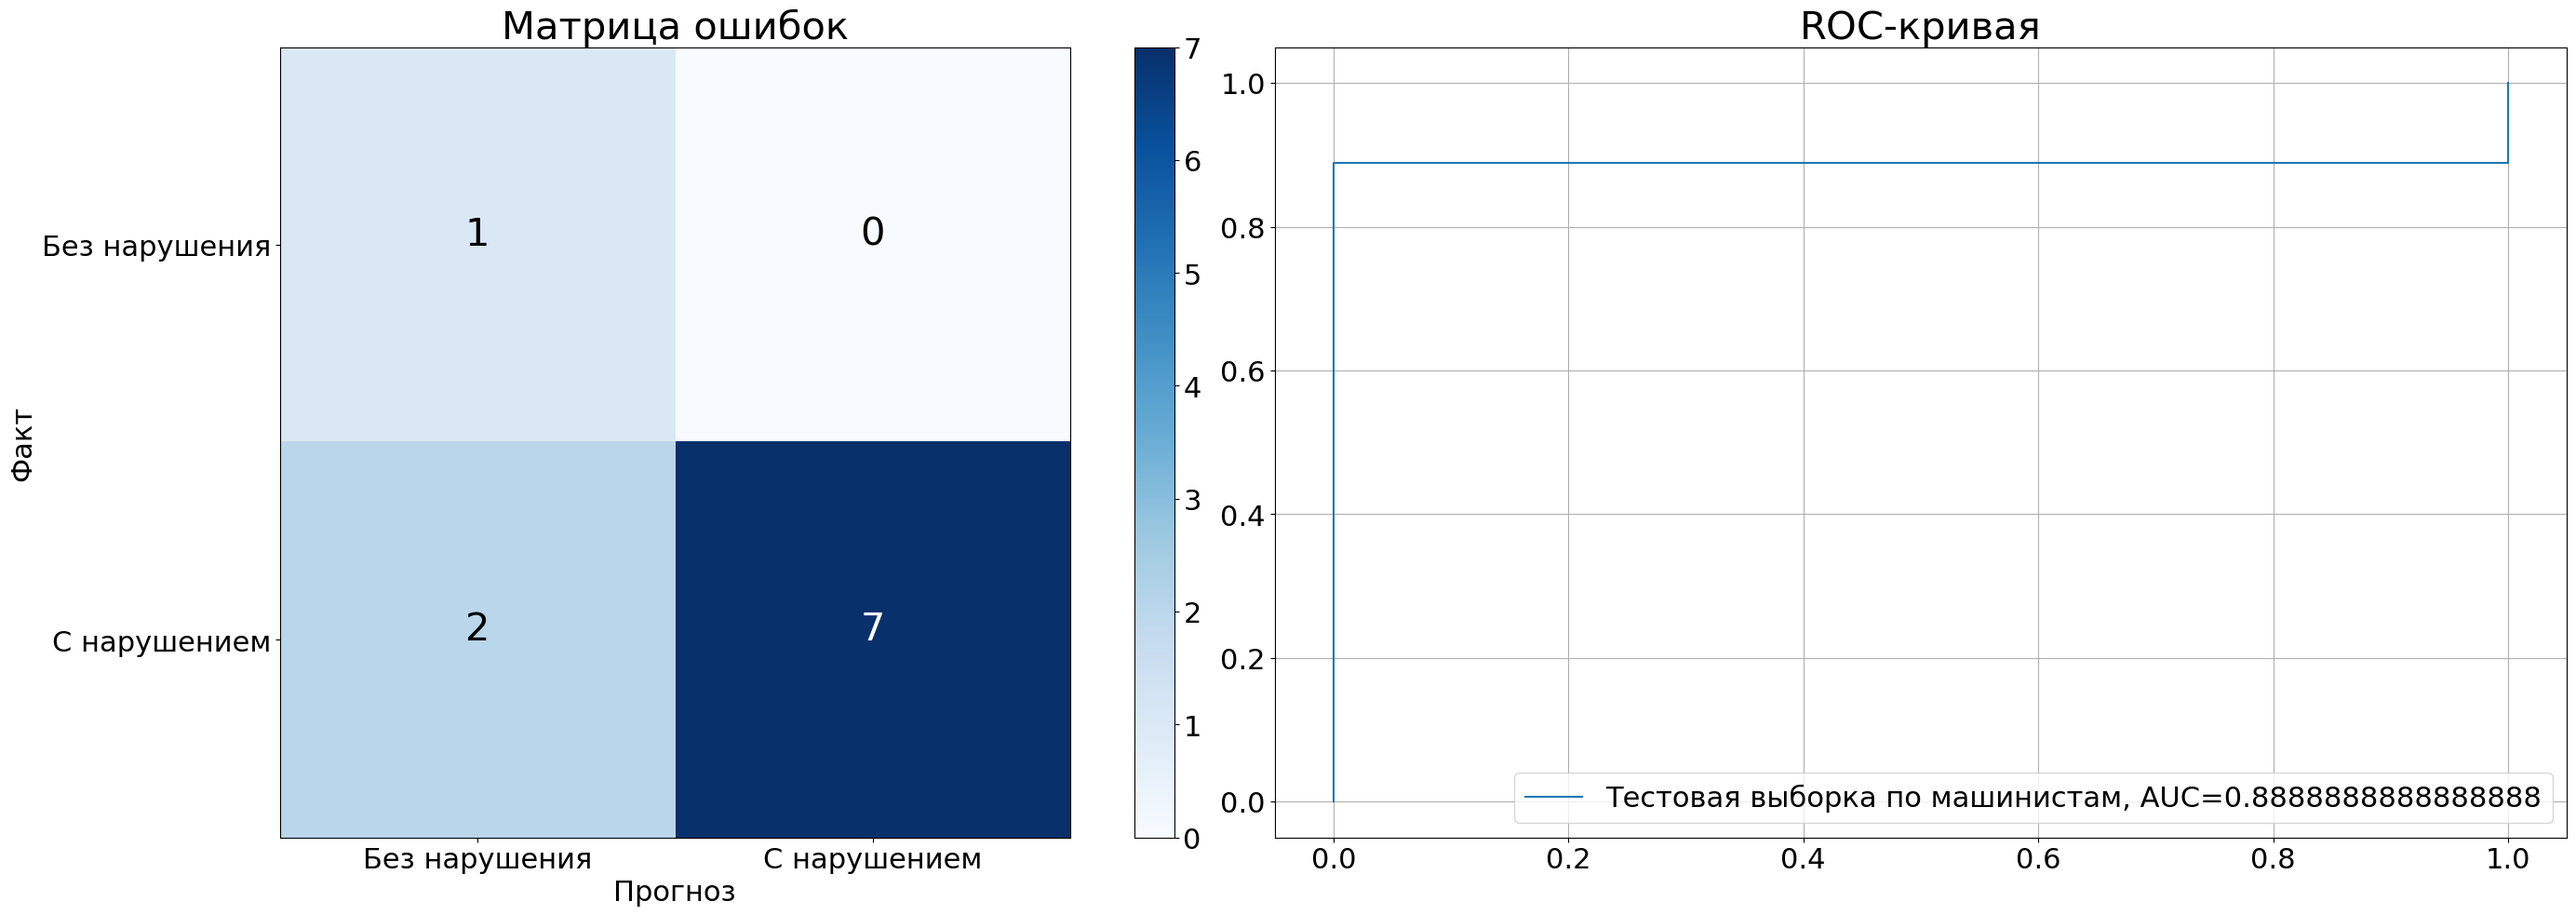

(0.8888888888888888, 0.875)

In [14]:
plot_helper.plotTableAUCRoc(model, X_test, y_test, thresholder=0.5, normalize=False)

<Axes: >

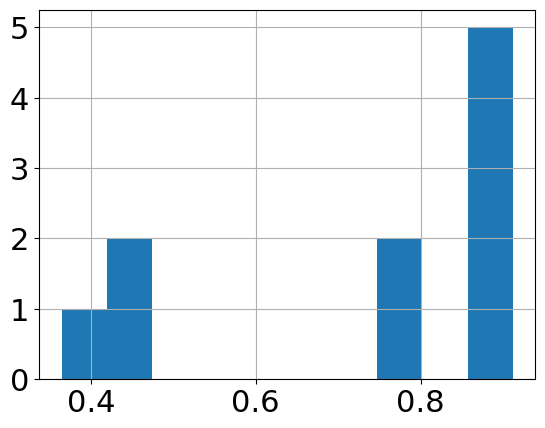

In [15]:
pd.Series(model.predict_proba(X_test)[:, 1]).hist()

In [16]:
model.predict_proba(X_test)

array([[0.10985249, 0.89014751],
       [0.09833364, 0.90166636],
       [0.12852584, 0.87147416],
       [0.57412929, 0.42587071],
       [0.23126794, 0.76873206],
       [0.08833596, 0.91166404],
       [0.13543118, 0.86456882],
       [0.63525163, 0.36474837],
       [0.23830456, 0.76169544],
       [0.57688594, 0.42311406]])

In [17]:
model.predict_proba(X_test[:10])

array([[0.10985249, 0.89014751],
       [0.09833364, 0.90166636],
       [0.12852584, 0.87147416],
       [0.57412929, 0.42587071],
       [0.23126794, 0.76873206],
       [0.08833596, 0.91166404],
       [0.13543118, 0.86456882],
       [0.63525163, 0.36474837],
       [0.23830456, 0.76169544],
       [0.57688594, 0.42311406]])

In [18]:
model.save_model("name")

In [32]:
new_m = CatBoostClassifier()

In [33]:
new_w = new_m.load_model("name")

In [46]:
r = new_w.predict(arr_embeddings)

In [47]:
for i in range(len(r)):
    print(bool(r[i]))

True
True
True
True
True
True
True
True
True
True
True
False
False
False
True
False
True
True
False
True
True
True
True
True
True
False
True
True
False
False
False
True
True
False
True
False
True
True
False
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
False
True
False
True
False
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
False
True
True
True
False
True
True
False
True
